In [1]:
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim
import os

In [2]:
class LJ8_3(nn.Module):
    """Feedfoward neural network with 2 hidden layer"""
    def __init__(self, in_size, hidden_size,hidden_size2, out_size):
        super().__init__()
        # 1st hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # 2nd hidden layer
        self.linear2 = nn.Linear(hidden_size,hidden_size2)
        # output layer
        self.linear3 = nn.Linear(hidden_size2, out_size)
        
    def forward(self, xb):
        # Get information from the data
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        tanhf = nn.ReLU()
        out = tanhf(out)
        # Get predictions using output layer
        out = self.linear2(out)
        # apply activation function again
        out = tanhf(out)
        # last hidden layer 
        out = self.linear3(out)
        #sigmoid function
        out = torch.sigmoid(out)
        return out

## beta = 10

In [42]:
beta = 20
fname = "Data/Committor_min01_CV_orderedcoordnum2_BETA"+str(beta) + '.npz'
inData = np.load(fname)
pts_10 = inData["points"]
Q_10 = inData["committor"]
tri = inData['tri']
CVlist = inData['CVlist']
print(f"Shape of trajectory data:{pts_10.shape}")
train_data_10 = torch.tensor(pts_10,dtype=torch.float32)
Q_10 = torch.tensor(Q_10,dtype=torch.float32)
ptsA = torch.tensor(np.loadtxt("FEMdataBETA" + str(beta) +"/ptsA.csv", delimiter=','), dtype=torch.float32)
ptsB = torch.tensor(np.loadtxt("FEMdataBETA" + str(beta) +"/ptsB.csv", delimiter=','), dtype=torch.float32)

# tri = np.loadtxt("FEMdataBETA"+str(beta)+"/" +"tri.csv", delimiter=',', dtype=int)
# print(tri.shape, "FEMdataBETA"+str(beta)+"/" +"tri.csv")

train_data_10 = torch.cat((train_data_10, ptsA, ptsB), 0)
Q_10 = torch.cat((Q_10, torch.zeros(len(ptsA)), torch.ones(len(ptsB))), 0)
train_data_10.requires_grad_(True)

# initialization
input_size = 2
output_size = 1
if beta == 10 or beta == 15:
    model = LJ8_3(input_size,10,10,output_size)
elif beta == 20:
    model = LJ8_3(input_size,25, 25,output_size)
    
train_ds = TensorDataset(train_data_10,Q_10)
batch_size = 512
print(f"batch size:{batch_size}")
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 200, 300, 400], gamma=0.5)


Shape of trajectory data:(7468, 2)
batch size:512


In [43]:
save_folder = "Data/Committor_min01_CV_orderedcoordnum2_BETA"+str(beta)

for name, param in model.named_parameters():
    shape_str = ",".join(map(str, param.shape))
    filename = os.path.join(save_folder, f"{name.replace('.', '_')}_[{shape_str}].csv")

    if os.path.exists(filename):
        param_data = np.loadtxt(filename, delimiter=",")  # Load CSV data
        param_data = torch.tensor(param_data, dtype=param.dtype)  # Convert to tensor

        # **Fix shape mismatches**
        if param.shape != param_data.shape:
            if len(param.shape) == 2 and len(param_data.shape) == 1:
                param_data = param_data.view(param.shape)  # Reshape 1D -> 2D
            elif len(param.shape) == 1 and param_data.numel() == 1:
                param_data = param_data.view(1)  # Reshape scalar -> (1,)
            else:
                print(f"Skipping {name} due to incompatible shape {param_data.shape}")

        # Load into model if shape matches
        if param.shape == param_data.shape:
            param.data.copy_(param_data)
            print(f"Loaded: {filename}")
        else:
            print(f"Shape mismatch for {name}: expected {param.shape}, got {param_data.shape}")
    else:
        print(f"File not found: {filename}")

# Set model to evaluation mode
model.eval()


Loaded: Data/Committor_min01_CV_orderedcoordnum2_BETA20/linear1_weight_[25,2].csv
Loaded: Data/Committor_min01_CV_orderedcoordnum2_BETA20/linear1_bias_[25].csv
Loaded: Data/Committor_min01_CV_orderedcoordnum2_BETA20/linear2_weight_[25,25].csv
Loaded: Data/Committor_min01_CV_orderedcoordnum2_BETA20/linear2_bias_[25].csv
Loaded: Data/Committor_min01_CV_orderedcoordnum2_BETA20/linear3_weight_[1,25].csv
Loaded: Data/Committor_min01_CV_orderedcoordnum2_BETA20/linear3_bias_[1].csv


LJ8_3(
  (linear1): Linear(in_features=2, out_features=25, bias=True)
  (linear2): Linear(in_features=25, out_features=25, bias=True)
  (linear3): Linear(in_features=25, out_features=1, bias=True)
)

In [44]:
# for epoch in range(1000):
#     for X,y in train_dl:
#         optimizer.zero_grad()

#         Q = model(X)

#         loss = loss_fn(Q.squeeze(), y)
#         loss.backward()
#         optimizer.step()
#     scheduler.step()

#     if epoch%25 == 0:
#         print('Epoch: {}, Loss : {:.4f}'.format(epoch, loss))

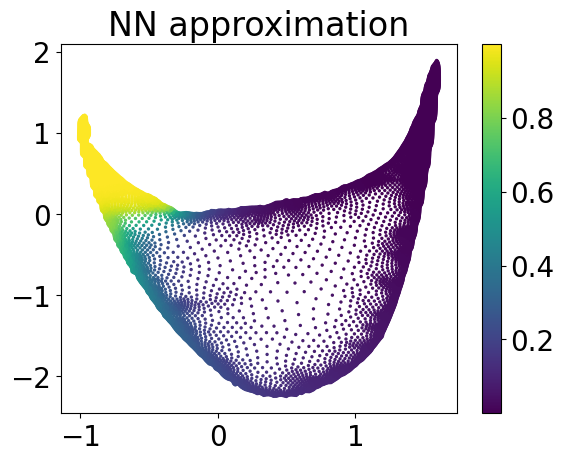

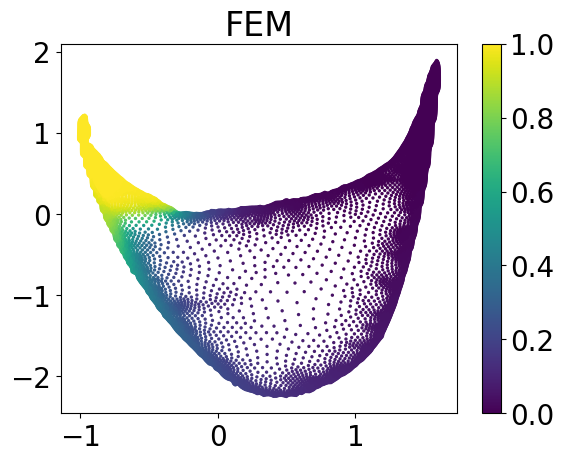

In [45]:
# comparison

q_model = model(train_data_10)
plt.figure()
plt.scatter(train_data_10[:,0].detach(), train_data_10[:,1].detach(), s = 2, c = q_model.detach().numpy())
plt.title("NN approximation")
plt.colorbar()

plt.figure()
plt.scatter(train_data_10[:,0].detach(), train_data_10[:,1].detach(), s = 2, c = Q_10.detach().numpy())
plt.title("FEM")
plt.colorbar()

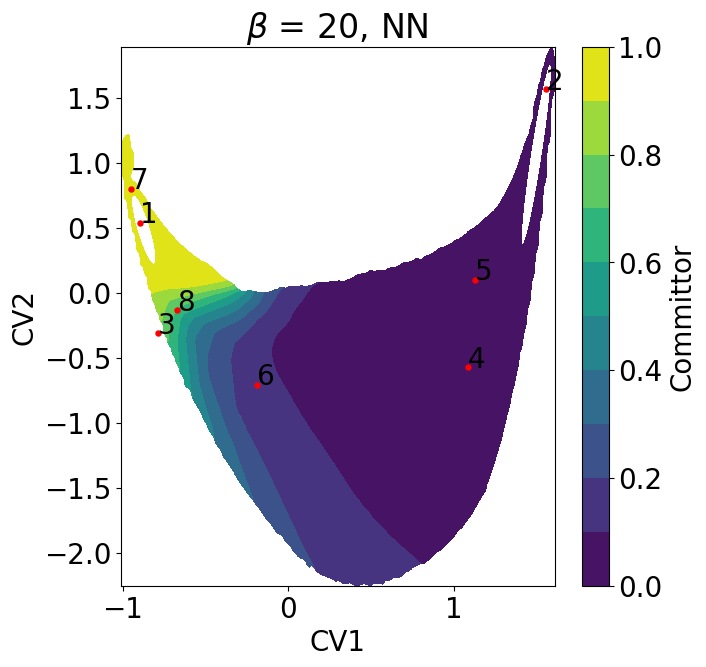

In [46]:
q = model(torch.tensor(pts_10, dtype = torch.float32))
plt.figure(figsize=(7,7))    
plt.rcParams.update({'font.size': 20})
plt.tricontourf(pts_10[:,0], pts_10[:,1],tri,q[:,0].detach(),np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]))
plt.colorbar(label="Committor", orientation="vertical")
# levels = 0.1*np.array([0., 0.3, 0.79, 1.29, 1.78, 2.28, 2.77, 3.27, 3.76, 4.26, 5.25, 5.74, 6.24, 6.73, 7.23, 7.72, 8.22, 8.71, 9.21, 9.7, 10.0])
# plt.tricontour(pts_10[:,0], pts_10[:,1],tri, q[:,0].detach(),levels, cmap = 'coolwarm')
plt.scatter(CVlist[:,0],CVlist[:,1],s = 13, c = 'red')
for j in range(8):
    plt.text(CVlist[j,0],CVlist[j,1],str(j+1),color = 'black')
plt.xlabel("CV1")
plt.ylabel("CV2")
plt.title(r'$\beta$' + ' = ' + str(beta) + ', NN')
# axes=plt.gca()
# axes.set_aspect(1)

fname = "Figures/NN_Committor_min01_CV_orderedcoordnum2_BETA"+str(beta)+".pdf"
plt.savefig(fname)

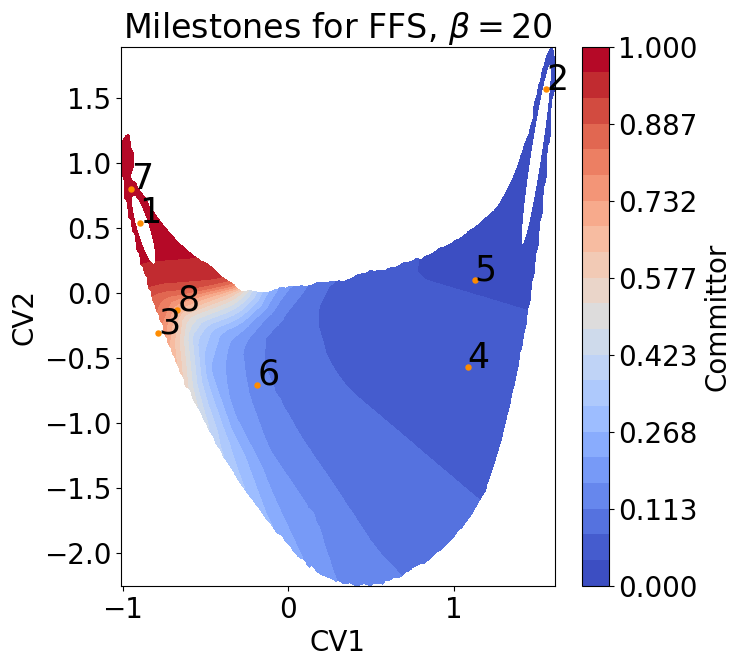

In [57]:
q = model(torch.tensor(pts_10, dtype = torch.float32))
plt.figure(figsize=(7,7))    
plt.rcParams.update({'font.size': 20})
if beta == 10:
    levels = 0.1*np.array([0., 0.3, 0.79, 1.29, 1.78, 2.28, 2.77, 3.27, 3.76, 4.26, 5.25, 5.74, 6.24, 6.73, 7.23, 7.72, 8.22, 8.71, 9.21, 9.7, 10.0])
elif beta == 15:
    levels = 0.1*np.array([0., 0.2, 0.71, 1.21, 1.72, 2.22, 2.72, 3.23, 3.74, 4.24, 5.25, 5.76, 6.26, 6.77, 7.27, 7.78, 8.28, 8.79, 9.29, 9.8, 10.0])
elif beta == 20:
    levels = 0.1*np.array([0,0.1,0.62, 1.13, 1.65, 2.16, 2.68, 3.19, 3.71, 4.23, 4.74, 5.26, 5.77, 6.29, 6.80, 7.32, 7.84, 8.35, 8.87, 9.38, 9.9, 10.0])
plt.tricontourf(pts_10[:,0], pts_10[:,1],tri,q[:,0].detach(),levels, cmap = 'coolwarm')
plt.colorbar(label="Committor", orientation="vertical")
plt.scatter(CVlist[:,0],CVlist[:,1],s = 13, c = 'darkorange')
for j in range(8):
    plt.text(CVlist[j,0],CVlist[j,1],str(j+1),color = 'black',fontsize=25)
# plt.colorbar()
plt.xlabel("CV1")
plt.ylabel("CV2")
plt.title(r'Milestones for FFS, $\beta =$' + str(beta))
axes=plt.gca()
# axes.set_facecolor('linen')
fname = "Figures/NN_Committor_levels_min01_CV_orderedcoordnum2_BETA"+str(beta)+".pdf"
# plt.savefig(fname)


In [19]:
save_folder = "Data/Committor_min01_CV_orderedcoordnum2_BETA"+str(beta)
os.makedirs(save_folder, exist_ok=True)  # Create folder if not exists

# Loop through each named parameter in the model
for name, param in model.named_parameters():
    shape_str = ",".join(map(str, param.shape))  # Convert shape tuple to string (e.g., "10x5")
    filename = os.path.join(save_folder, f"{name.replace('.', '_')}_[{shape_str}].csv")  # Include shape in filename
    np.savetxt(filename, param.detach().cpu().numpy(), delimiter=',')  # Save as .npy
    print(f"Saved: {filename}")

Saved: Data/Committor_min01_CV_orderedcoordnum2_BETA20/linear1_weight_[25,2].csv
Saved: Data/Committor_min01_CV_orderedcoordnum2_BETA20/linear1_bias_[25].csv
Saved: Data/Committor_min01_CV_orderedcoordnum2_BETA20/linear2_weight_[25,25].csv
Saved: Data/Committor_min01_CV_orderedcoordnum2_BETA20/linear2_bias_[25].csv
Saved: Data/Committor_min01_CV_orderedcoordnum2_BETA20/linear3_weight_[1,25].csv
Saved: Data/Committor_min01_CV_orderedcoordnum2_BETA20/linear3_bias_[1].csv


## beta = 15

In [15]:
beta = 15
fname = "Data/Committor_min01_LDA12_BETA"+str(beta) + '.npz'
inData = np.load(fname)
pts_15 = inData["points"]
Q_15 = inData["committor"]
print(f"Shape of trajectory data:{pts_15.shape}")
train_data_15 = torch.tensor(pts_15,dtype=torch.float32)
Q_15 = torch.tensor(Q_15,dtype=torch.float32)
train_data_15.requires_grad_(True)

# initialization
input_size = 2
output_size = 1
model = LJ8_3(input_size,10,10,output_size)

train_ds = TensorDataset(train_data_15,Q_15)
batch_size = int(len(train_data_15)/64)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000], gamma=0.5)


Shape of trajectory data:(18485, 2)


In [ ]:
for epoch in range(1000):
    for X,y in train_dl:
        optimizer.zero_grad()

        Q = model(X)

        loss = loss_fn(Q.squeeze(), y)
        loss.backward()
        optimizer.step()

    if epoch%25 == 0:
        print('Epoch: {}, Loss : {:.4f}'.format(epoch, loss))

/Users/jiaxinyuan/opt/anaconda3/envs/myenv2/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([147])) that is different to the input size (torch.Size([147, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/jiaxinyuan/opt/anaconda3/envs/myenv2/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([110])) that is different to the input size (torch.Size([110, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Loss : 0.1283
Epoch: 25, Loss : 0.1176
Epoch: 50, Loss : 0.1088
Epoch: 75, Loss : 0.1264


In [ ]:
q_model = model(train_data_15)
plt.figure()
plt.scatter(pts_15[:,0], pts_15[:,1], c = q_model.detach().numpy())
plt.title("NN approximation")
plt.colorbar()

plt.figure()
plt.scatter(pts_15[:,0], pts_15[:,1], c = Q_15.detach().numpy())
plt.title("FEM")
plt.colorbar()

In [14]:
save_folder = "Data/Committor_min01_LDA12_BETA"+str(beta)
os.makedirs(save_folder, exist_ok=True)  # Create folder if not exists

# Loop through each named parameter in the model
for name, param in model.named_parameters():
    shape_str = ",".join(map(str, param.shape))  # Convert shape tuple to string (e.g., "10x5")
    filename = os.path.join(save_folder, f"{name.replace('.', '_')}_[{shape_str}].csv")  # Include shape in filename
    np.savetxt(filename, param.detach().cpu().numpy(), delimiter=',')  # Save as .npy
    print(f"Saved: {filename}")

Saved: Data/Committor_min01_LDA23_BETA10/linear1_weight_[10,2].csv
Saved: Data/Committor_min01_LDA23_BETA10/linear1_bias_[10].csv
Saved: Data/Committor_min01_LDA23_BETA10/linear2_weight_[10,10].csv
Saved: Data/Committor_min01_LDA23_BETA10/linear2_bias_[10].csv
Saved: Data/Committor_min01_LDA23_BETA10/linear3_weight_[1,10].csv
Saved: Data/Committor_min01_LDA23_BETA10/linear3_bias_[1].csv


## beta = 20

In [15]:
beta = 20
fname = "Data/Committor_min01_LDA12_BETA"+str(beta) + '.npz'
inData = np.load(fname)
pts_20 = inData["points"]
Q_20 = inData["committor"]
print(f"Shape of trajectory data:{pts_20.shape}")
train_data_20 = torch.tensor(pts_20,dtype=torch.float32)
Q_20 = torch.tensor(Q_20,dtype=torch.float32)
train_data_20.requires_grad_(True)

# initialization
input_size = 2
output_size = 1
model = LJ8_3(input_size,10,10,output_size)

train_ds = TensorDataset(train_data_20,Q_20)
batch_size = int(len(train_data_20)/64)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000], gamma=0.5)


Shape of trajectory data:(18485, 2)


In [ ]:
for epoch in range(1000):
    for X,y in train_dl:
        optimizer.zero_grad()

        Q = model(X)

        loss = loss_fn(Q.squeeze(), y)
        loss.backward()
        optimizer.step()

    if epoch%25 == 0:
        print('Epoch: {}, Loss : {:.4f}'.format(epoch, loss))

/Users/jiaxinyuan/opt/anaconda3/envs/myenv2/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([147])) that is different to the input size (torch.Size([147, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/jiaxinyuan/opt/anaconda3/envs/myenv2/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([110])) that is different to the input size (torch.Size([110, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Loss : 0.1283
Epoch: 25, Loss : 0.1176
Epoch: 50, Loss : 0.1088
Epoch: 75, Loss : 0.1264


In [ ]:
q_model = model(train_data_20)
plt.figure()
plt.scatter(pts_20[:,0], pts_20[:,1], c = q_model.detach().numpy())
plt.title("NN approximation")
plt.colorbar()

plt.figure()
plt.scatter(pts_20[:,0], pts_20[:,1], c = Q_20.detach().numpy())
plt.title("FEM")
plt.colorbar()

In [14]:
save_folder = "Data/Committor_min01_LDA12_BETA"+str(beta)
os.makedirs(save_folder, exist_ok=True)  # Create folder if not exists

# Loop through each named parameter in the model
for name, param in model.named_parameters():
    shape_str = ",".join(map(str, param.shape))  # Convert shape tuple to string (e.g., "10x5")
    filename = os.path.join(save_folder, f"{name.replace('.', '_')}_[{shape_str}].csv")  # Include shape in filename
    np.savetxt(filename, param.detach().cpu().numpy(), delimiter=',')  # Save as .npy
    print(f"Saved: {filename}")

Saved: Data/Committor_min01_LDA23_BETA10/linear1_weight_[10,2].csv
Saved: Data/Committor_min01_LDA23_BETA10/linear1_bias_[10].csv
Saved: Data/Committor_min01_LDA23_BETA10/linear2_weight_[10,10].csv
Saved: Data/Committor_min01_LDA23_BETA10/linear2_bias_[10].csv
Saved: Data/Committor_min01_LDA23_BETA10/linear3_weight_[1,10].csv
Saved: Data/Committor_min01_LDA23_BETA10/linear3_bias_[1].csv
